# Bayesian online changepoint detection of a counting process
## A one-dimensional implementation

In [17]:
import numpy as np
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta

In [257]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12

sns.set_palette("colorblind")

## The flip of a coin
```
heads: 1
tails: 0
```

Consider a random variable $p(x \vert \mu) = {\rm Bern}(x \vert \mu) = \mu ^ x\,(1 - \mu)^{1 - x}$

In [258]:
p = 0.3 # unknown probability
n_samples = 100
np.random.seed(314)
flips = np.random.choice(2, n_samples, p=np.array([1 - p, p]))
flips

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Is the coin biased?
Consider a Beta prior on the probability of a tails

$$
    {\rm Beta}(\mu \vert a, b) = \frac{\Gamma(a)\,\Gamma(b)}{\Gamma(a + b)} \mu^{a - 1}\,(1 - \mu)^{b - 1}
$$

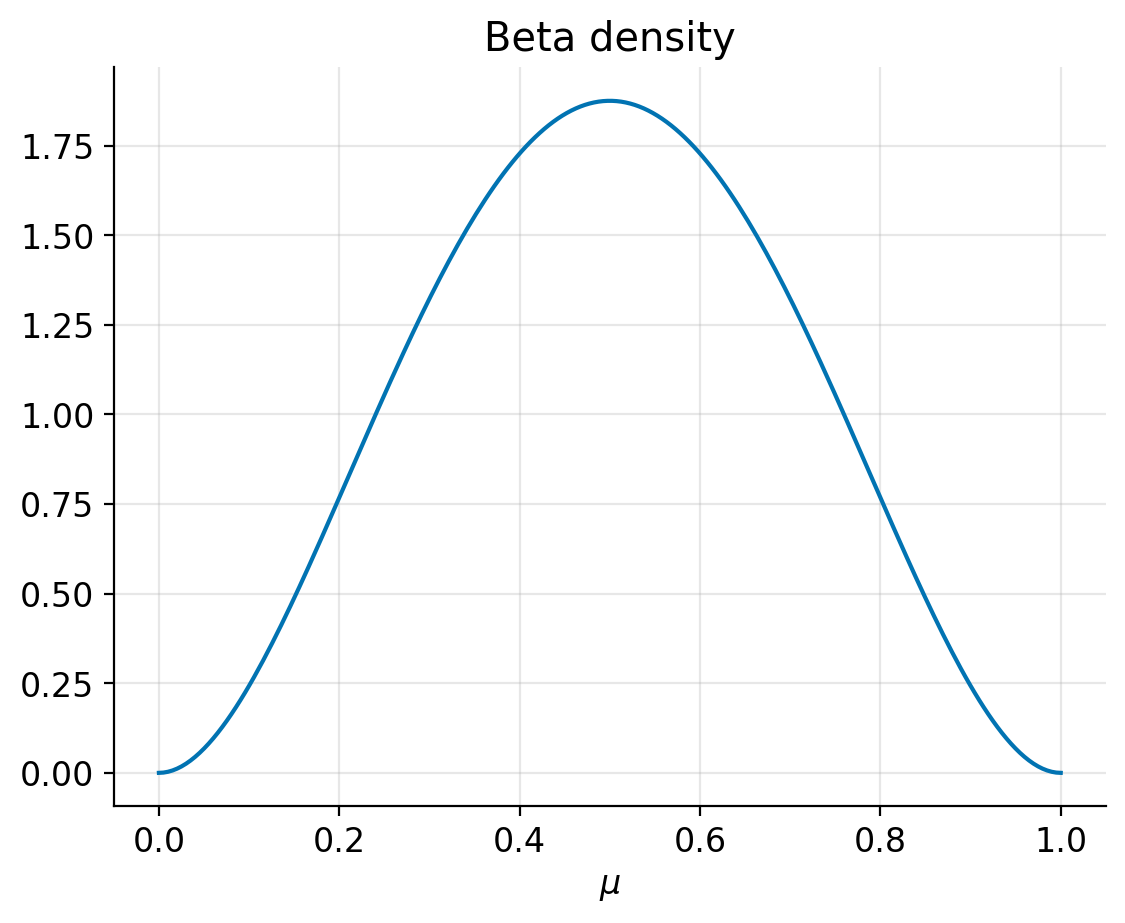

In [315]:
mu_vals = np.linspace(0, 1, 200)

a, b = 3, 3
density = beta.pdf(mu_vals, a=a, b=b)
plt.plot(mu_vals, density)
plt.title("Beta density")
plt.xlabel("$\mu$")
plt.grid(alpha=0.3)

We seek to find the density of the probability the toss of a coin,
conditioned on the measurements.
At $t=1$, we have
$$
\begin{aligned}
    p(\mu \vert y_{1})
    &\propto p(\mu)\,p(y_1 \vert \mu)\\
    &= {\rm Beta}(\mu \vert a_0, b_0)\,{\rm Bern}(y_1 \vert \mu)\\
    & \propto \mu^{a_0 - 1}\,(1 - \mu)^{b_0 - 1}\,\mu^{y_1}\,(1 - \mu)^{1 - y_1}\\
    & =\mu^{a_0 + y_1 - 1}\,(1 - \mu)^{b_0 + (1 - y_1) - 1}\\
    & = \mu^{a_1 - 1}\,(1 - \mu)^{b_1 - 1}\\
    &= {\rm Beta}(\mu \vert a_1, b_1),
\end{aligned}
$$
with $a_1 = a_0 + y_1$ and $b_1 = b_0 + (1 - y_1)$.

Following an inductive argument,
suppose $t > 1$ and $p(\mu \vert y_{1:t-1}) = {\rm Beta}(\mu \vert a_{t-1}, b_{t-1})$.
Then,
$$
\begin{aligned}
    p(\mu \vert y_{1:t})
    &\propto p(\mu \vert y_{1:t-1})\,p(y_t \vert \mu)\\
    &= {\rm Beta}(\mu \vert a_{t-1}, b_{t-1})\,{\rm Bern}(y_t \vert \mu)\\
    &= {\rm Beta}(\mu \vert a_t, b_t),
\end{aligned}
$$

with $a_t = a_{t-1} + y_t$ and $b_1 = b_{t-1} + (1 - y_t)$.

In [316]:
a_est = a
b_est = b

for t, flip in enumerate(flips):
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

expected_probability = a_est / (a_est + b_est)
expected_probability

0.46116504854368934

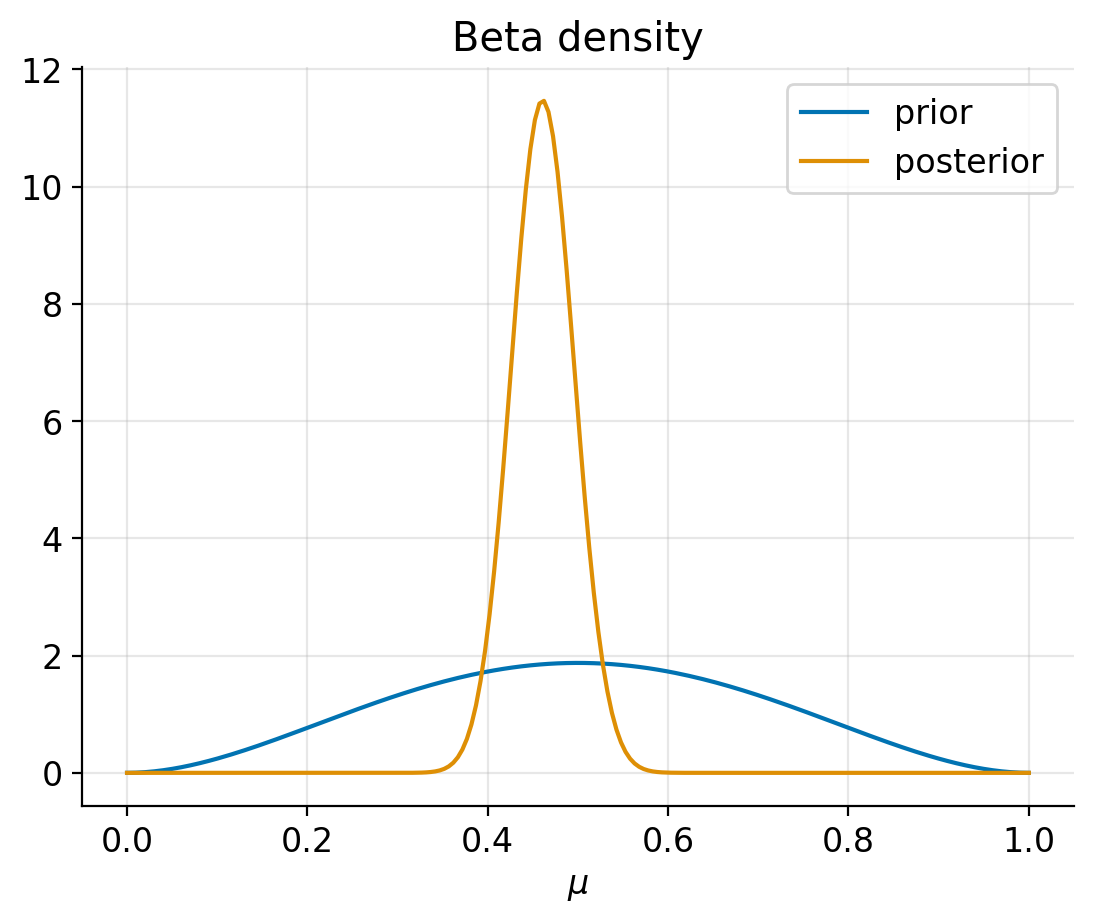

In [331]:
density_prior = beta.pdf(mu_vals, a=a, b=b)
density_posterior = beta.pdf(mu_vals, a=a_est, b=b_est)
plt.plot(mu_vals, density_prior, label="prior")
plt.plot(mu_vals, density_posterior, label="posterior")
plt.legend()
plt.title("Beta density")
plt.xlabel("$\mu$")
plt.grid(alpha=0.3)

In [336]:
posterior = beta(a=a_est, b=b_est)
posterior.interval(0.95)

(0.21867158129203312, 0.39218257171147397)

We can conclude that the coin in biased.

In [337]:
p = 0.3 # unknown probability
n_samples = 100
np.random.seed(314)
flips = np.random.choice(2, n_samples, p=np.array([1 - p, p]))

In [338]:
# a_hist, b_hist = np.zeros((2, n_samples))
# a_hist = np.zeros(n_samples)
# b_hist = np.zeros(n_samples)

mean_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

a_est = a
b_est = b

for t, flip in enumerate(flips):
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    mean_hist[t] = a_est / (a_est + b_est)
    
    pdensity = beta(a=a_est, b=b_est)
    lq_hist[t] = pdensity.ppf(0.25)
    uq_hist[t] = pdensity.ppf(0.75)

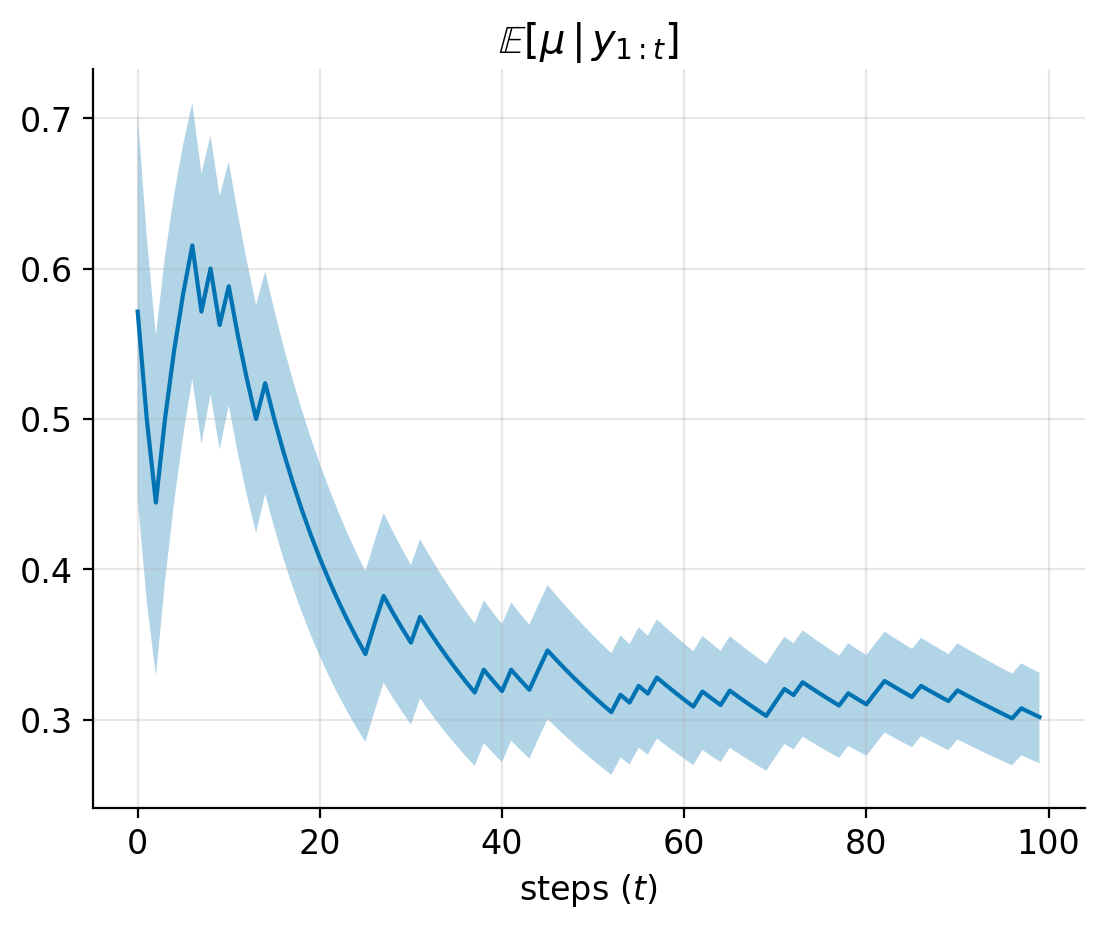

In [339]:
steps = np.arange(n_samples)
plt.plot(steps, mean_hist)
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3)
plt.xlabel("steps ($t$)")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")
plt.grid(alpha=0.3)

## Change in probability
Imagine that the probability of head becomes $\mu=0.6$ after 100 steps

In [340]:
n_samples = 200
np.random.seed(314)

p = 0.3 # unknown probability
flips_1 = np.random.choice(2, n_samples // 2, p=np.array([1 - p, p]))

p = 0.6 # unknown probability
flips_2 = np.random.choice(2, n_samples // 2, p=np.array([1 - p, p]))

flips = np.concatenate([flips_1, flips_2])

In [341]:
mean_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

a_est = a
b_est = b

for t, flip in enumerate(flips):
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    mean_hist[t] = a_est / (a_est + b_est)
    
    pdensity = beta(a=a_est, b=b_est)
    lq_hist[t] = pdensity.ppf(0.25)
    uq_hist[t] = pdensity.ppf(0.75)

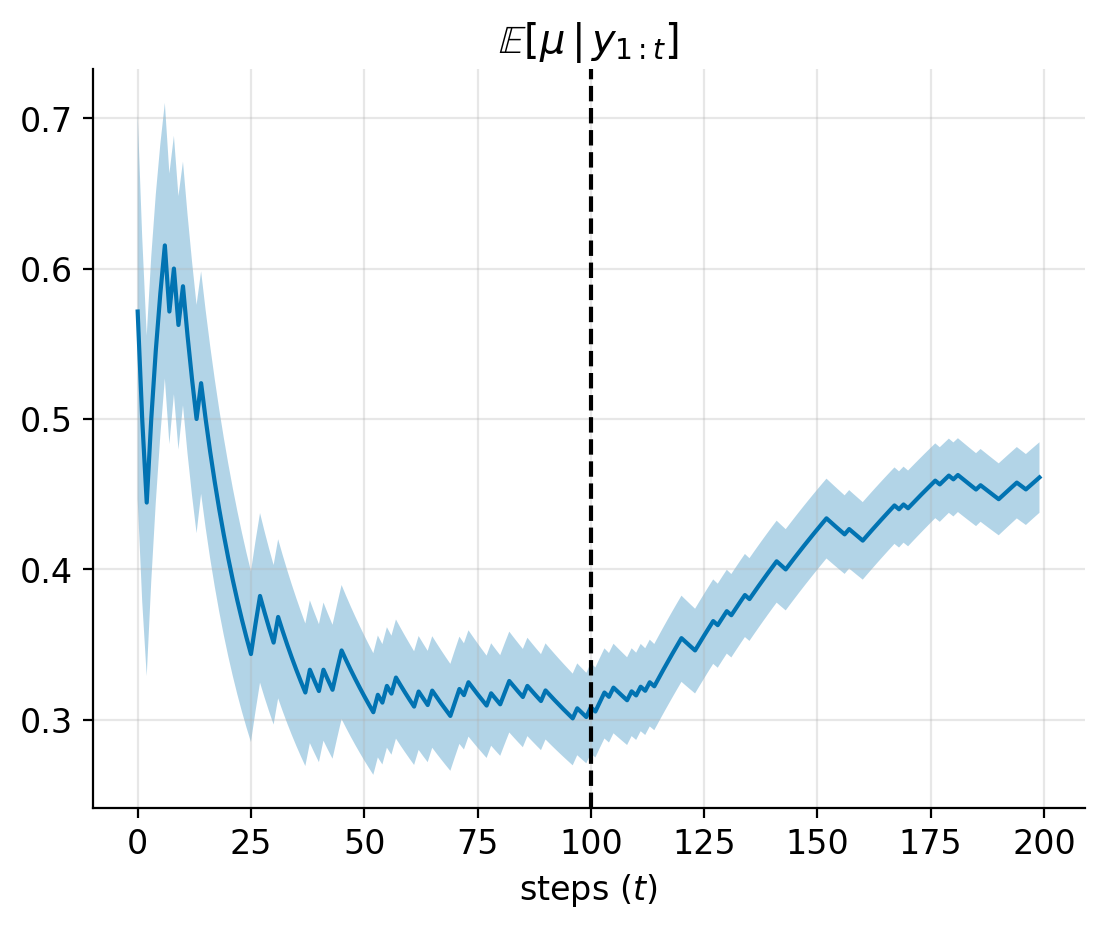

In [342]:
steps = np.arange(n_samples)
plt.plot(steps, mean_hist)
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3)
plt.axvline(x=n_samples // 2, c="black", linestyle="--")
plt.xlabel("steps ($t$)")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")
plt.grid(alpha=0.3)

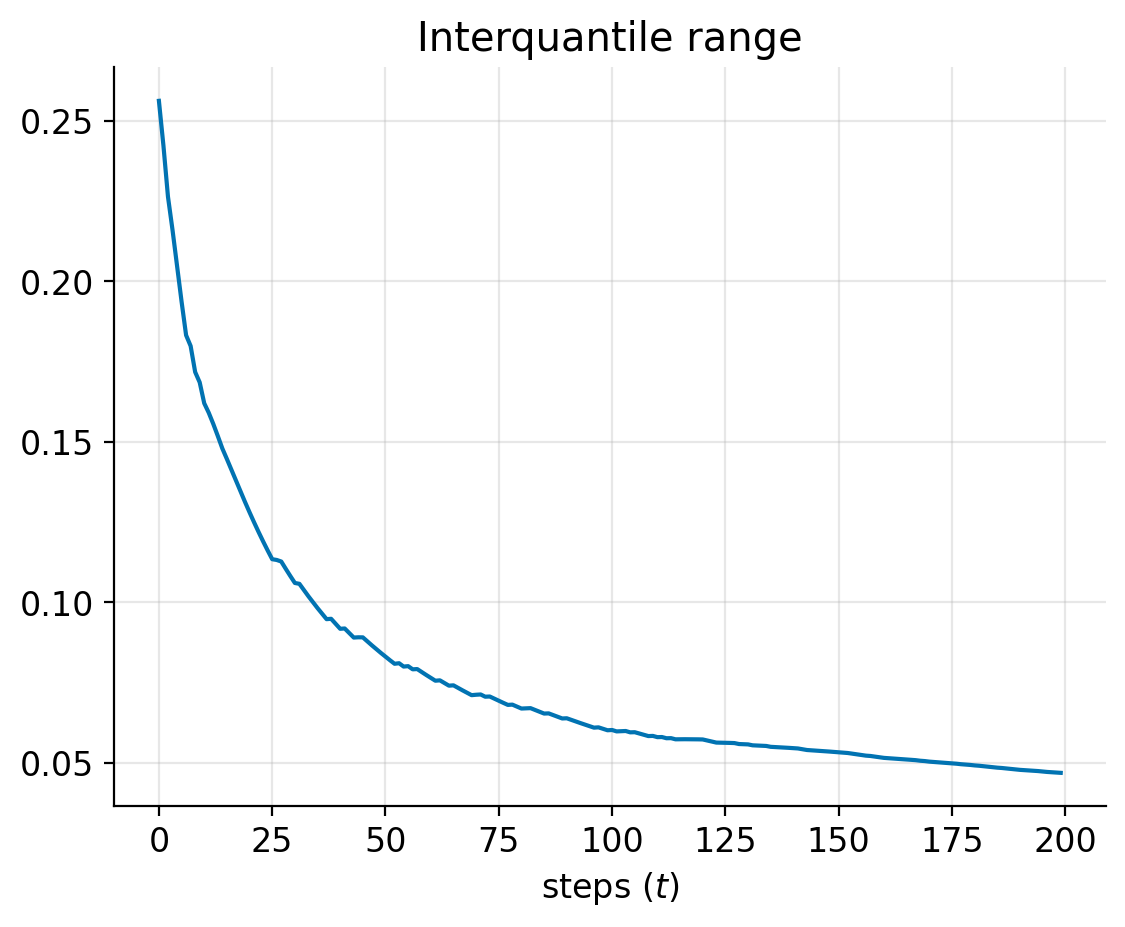

In [343]:
plt.plot(uq_hist - lq_hist)
plt.xlabel("steps ($t$)")
plt.title(r"Interquantile range")
plt.grid(alpha=0.3)

The uncertainty decreases regardless of the change in estimate!

To overcome this, we could ask the following question:
when was the last time that a *changepoint* ocurred?
By changepoint, we mean that the values of $a$ and $b$ change.

If we were to have access to this number, then we could re-set the algorithm
with the initial estimate in mean and variance and start from $0$.

In [344]:
n_samples = 200
np.random.seed(314)

p = 0.3 # unknown probability
flips_1 = np.random.choice(2, n_samples // 2, p=np.array([1 - p, p]))

p = 0.6 # unknown probability
flips_2 = np.random.choice(2, n_samples // 2, p=np.array([1 - p, p]))

flips = np.concatenate([flips_1, flips_2])

In [345]:
mean_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

a_est = a
b_est = b

for t, flip in enumerate(flips):

    # Reset if changepoint
    if t == 100:
        a_est, b_est = a, b
    
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    mean_hist[t] = a_est / (a_est + b_est)
    
    pdensity = beta(a=a_est, b=b_est)
    lq_hist[t] = pdensity.ppf(0.25)
    uq_hist[t] = pdensity.ppf(0.75)

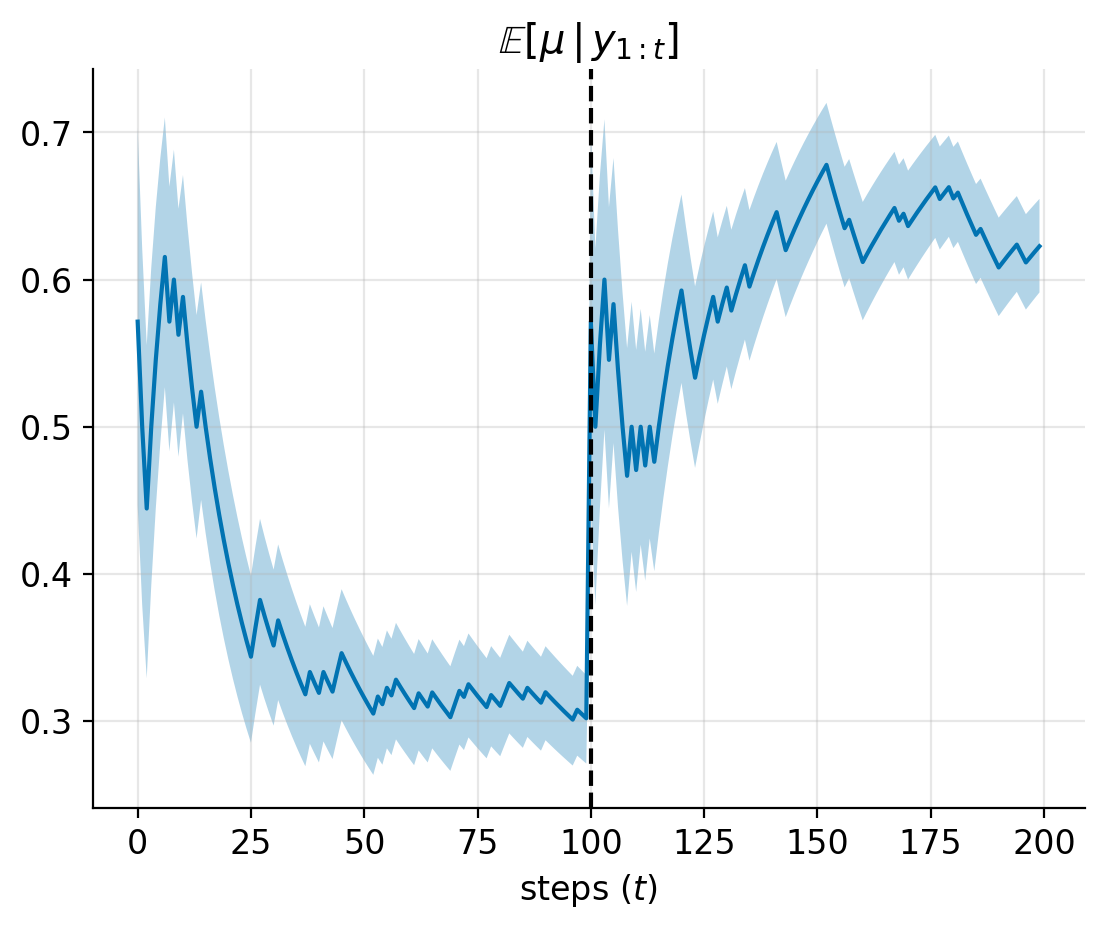

In [346]:
steps = np.arange(n_samples)
plt.plot(steps, mean_hist)
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3)
plt.axvline(x=n_samples // 2, c="black", linestyle="--")
plt.xlabel("steps ($t$)")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")
plt.grid(alpha=0.3)

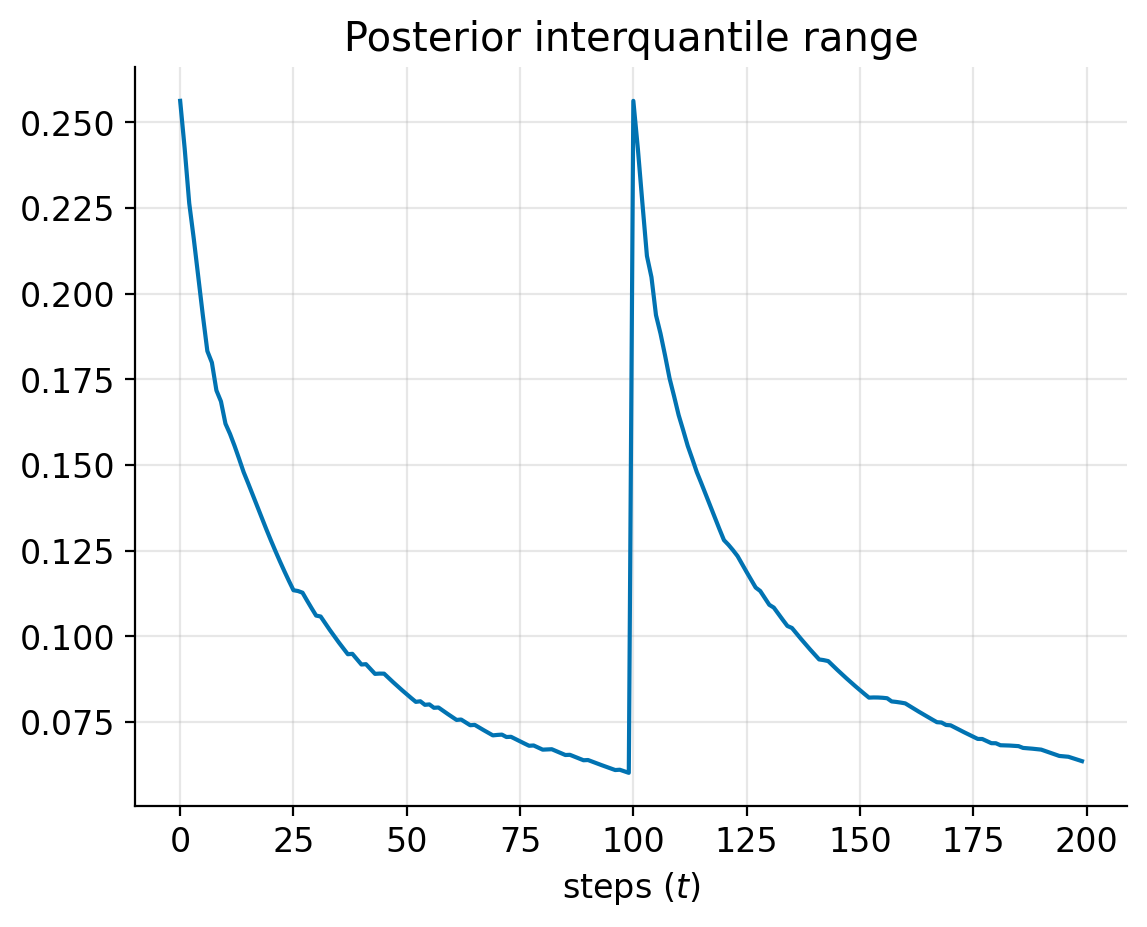

In [349]:
plt.plot(uq_hist - lq_hist)
plt.xlabel("steps ($t$)")
plt.title(r"Posterior interquantile range")
plt.grid(alpha=0.3)

In reality, we do not have concrete evidence on the last occurence of a changepoint.
To go around this problem, we assume that the time since the last changepoint
is another random variable.
We call this variable the _runlength_ and we denote it by $r_t \in \{0, \ldots, t\}$.

$$
    p(r_t\,\vert\,y_{1:t}) = \frac{p(r_t,\,y_{1:t})}{\sum_{\ell=0}^tp(r_t=\ell, y_{1:t})}
$$

With this quantity, we define the influence on the posterior as
$$
    p(\mu \vert r_t=k, y_{1:t}) = p(\mu \vert y_{t-k:t}) = {\rm Beta}(\mu \vert a_{t-k:t}, b_{t-k:t}),
$$
with
$a_{t-k:t} = a_0 + \sum_{j=0}^k y_{t - k + j}$ and
$b_{t-k:t} = b_0 + k - \sum_{j=0}^k y_{t - k + j}$.

This last equation simply means that if a changepoint happened $k$ steps ago,
the posterior only considers the last $k$ observations, i.e.,
from $y_{t-k}$ to $y_t$.

The main quantity of interest is $p(r_t,\,y_{1:t})$ and it takes the form
$$
\begin{aligned}
p(r_t=k,\,y_{1:t})
&= \sum_{j=1}^{t-1} p(r_t = k, r_{t-1}=j, y_{1:t})\\
&= \sum_{j=1}^{t-1} p(r_t = k, r_{t-1}=j, y_{1:t-1}, y_t)\\
&= \sum_{j=1}^{t-1} p(r_{t-1}=j, y_{1:t-1})\,p(r_t=k,\,y_t\vert r_{t-1}=j, y_{1:t-1})\\
&= \sum_{j=1}^{t-1} p(r_{t-1}=j, y_{1:t-1})\,p(r_t=k,\,y_t\vert r_{t-1}=j, y_{1:t-1})\\
&= \sum_{j=0}^{t-1}
    \underbrace{
    p(r_{t-1}=j, y_{1:t-1})
    }_{({\rm A})}
    \,
    \underbrace{
    p(r_t=k,\vert r_{t-1}=j, y_{1:t-1})
    }_{({\rm B})}
    \,
    \underbrace{
    p(y_t \vert r_t=k, r_{t-1}=j, y_{1:t-1})
    }_{({\rm C})}
\end{aligned}
$$

The value of $({\rm A})$ is assumed to be computed at time $t-1$ for $j=1,\ldots, t-1$.

Next, $r_t$ is assumed to be independent on the $y_{1:t-1}$ conditioned on $r_{t-1}$. So that $(\text{B})$ becomes
$$
    p(r_t = k \vert r_{t-1} = j) =
    \begin{cases}
    H(r_t) & k = 0,\\
    1 - H(r_t) & k = j + 1,\\
    0 & \text{otherwise}.
    \end{cases}
$$

Finally, $(\text{C})$
$$
    p(y_t \vert r_t=k, r_{t-1}=j, y_{1:t-1}) = p(y_t \vert r_t=k, y_{1:t-1})
$$
with
$$
\begin{aligned}
    p(y_t \vert r_t=k, y_{1:t-1})
    &= \int p(\mu, y_t \vert r_t =k, y_{1:t-1}) {\rm d}\mu\\
    &= \int p(\mu \vert r_t =k, y_{1:t-1})\,p(y_t \vert \mu) {\rm d}\mu\\
    &= \int p(\mu \vert y_{t-1-k:t-1})\,p(y_t \vert \mu) {\rm d}\mu\\
    &= \int {\rm Beta}(\mu \vert a_{t-1-k:t-1}, b_{t-1-k:t-1})\,{\rm Bern}(y_t \vert \mu)  {\rm d}\mu\\
    &= \int
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \mu^{a_{t-1-k:t-1}}\,(1 - \mu)^{b_{t-1-k:t-1}}\,\mu^{y_t}\,(1-\mu)^{1 - y_t} {\rm d}\mu\\
    &=
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \int\mu^{a_{t-1-k:t-1}}\,(1 - \mu)^{b_{t-1-k:t-1}}\,\mu^{y_t}\,(1-\mu)^{1 - y_t} {\rm d}\mu\\
    &= 
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \frac{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1} + y_t + 1 - y_t)}
    {\Gamma(a_{t-1-k:t-1} + y_t)\Gamma(b_{t-1-k:t-1} + 1 - y_t)}\\
    &= 
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \frac{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1} + 1)}
    {\Gamma(a_{t-1-k:t-1} + y_t)\Gamma(b_{t-1-k:t-1} + 1 - y_t)}
\end{aligned}
$$

Note that $z\Gamma(z)$ = $\Gamma(z + 1)$. Then,
$$
\begin{aligned}
    &\frac{\Gamma(a_{t-1-k:t-1} + 1)\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1} + 1)}\\
    =&\frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \frac{a_{t-1-k:t-1}}{a_{t-1-k:t-1} + b_{t-1-k:t-1}}
\end{aligned}
$$

So that
$$
    p(y_t \vert r_t, y_{1:t-1})
    =\frac{a_{t-1-k:t-1}}{a_{t-1-k:t-1} + b_{t-1-k:t-1}}
$$
for $y_t = 1$.

With these equations, we see that
$$
    p(r_{t+1} = k, y_{1:t+1}) = p(r_{t} = k-1, y_{1:t})\,(1 - H(k))\,\frac{y_{t+1}\,a_{t-k:t} + (1 - y_{t+1})\,b_{t-k:t}}{a_{t-k:t} + a_{t-k:t}}
$$
for $k > 0$ and

$$
    p(r_{t+1} = 0, y_{1:t+1}) =
    \frac{y_t\,a_{t-k:t} + (1 - y_t)\,b_{t-k:xt}}{a_{t-k:t} + a_{t-k:t}}\sum_{j=0}^t p(r_{t-1} = j, y_{1:t-1})\,H(j)
$$

## Implementation

To avoid number underflow, we compute the log-joint. We obtain

$$
\log p(r_{t+1} = k, y_{1:t+1}) = 
\log\left(\frac{y_{t+1}\,a_{t-k:t} + (1 - y_{t+1})\,b_{t-k:t}}{a_{t-k:t} + b_{t-k:t}}\right) + 
\begin{cases}
    \log p(r_{t} = k-1, y_{1:t}) + \log(1 - H(k)) & k > 0,\\
    \log\sum_{j=0}^t\exp\left(\log p(r_t = j, y_{1:t}) + \log H(j)\right) & k = 0.
\end{cases}
$$

In [ ]:
def logsumexp(x):
    ...


def log_predict(a, b, y):
    return np.log(y * a + (1 - y) * b) - np.log(a + b)


def update_log_joint(k, y, log_joint_prev, coefs, hazard):
    a, b = coefs[k]
    log_joint = log_predict(a, b, y)
    
    if k > 0:
        log_joint = log_joint + log_prev[k-1] + np.log(1 - hazard)
    else:
        log_joint = log_joint + logsumexp(log_joint_prev) + np.log(hazard)

    return log_joint